# ML Defect Morphology to Spectrum: Final Analysis

**Objective**: Demonstrate how defect morphology governs spectral perturbations, distinguishing between predictable local effects and nonlocal/systematic deviations.

**Key Goals**:
1.  **Physically Grounded ML**: Use morphology features (distance, type, counts) to predict spectral changes.
2.  **Full Spectral Prediction**: Move beyond peak shifts to predicting the entire spectral curve ($9.7 - 12.5 \mu m$).
3.  **Nonlocal Physics Isolation**: Quantify the contribution of global fabrication gradients versus local defect impact.

**Structure**:
-   **Section 1**: Data Audit & Physical Framing
-   **Section 2**: Stronger Predictive Modeling (Grouped CV)
-   **Section 3**: Full Spectral Response (PCA-based)
-   **Section 4**: Physical Interpretability (SHAP)
-   **Section 5**: Residual Physics Analysis
-   **Section 6**: Statistical Significance
-   **Section 7**: Publication Figures
-   **Section 8**: Outputs

## SECTION 1: Data Audit and Physical Framing

In [10]:
import sys
import os
from pathlib import Path

# Add src directory to path
current_dir = Path(os.getcwd())
root_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
src_dir = str(root_dir / "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import cdist

# Ensure project root is in path
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from defect_analysis.ml import ftir_utils, dataset_assembly, ml_models, feature_extraction

# Plotting Setup
plt.rcParams.update({
    "figure.dpi": 150,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16
})

# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
OUTPUT_DIR = PROJECT_ROOT / "ml_outputs" / "Final_Paper"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

Project Root: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects
Data Directory: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\data
Output Directory: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\ml_outputs\Final_Paper


### 1.1 Load Data and Classifications

In [11]:
# Load Raw FTIR Spectra
try:
    array_data = ftir_utils.load_all_arrays(str(DATA_DIR))
    print(f"Loaded arrays: {list(array_data.keys())}")
except Exception as e:
    print(f"Error loading arrays: {e}")

# Load Classifications
class_csv = RESULTS_DIR / "meta_atoms_classified.csv"
classifications = ftir_utils.load_classifications(str(class_csv))
print(f"Loaded classifications for: {list(classifications.keys())}")

Loaded arrays: ['Array_1.0', 'Array_2.0', 'Array_3.0', 'Array_4.0']
Loaded classifications for: ['Array_1Crop', 'Array_2Crop', 'Array_3Crop']


### 1.2 Build Feature Matrix (Morphology Inputs + Spectral Targets)

We construct the dataset with:
-   **Inputs**: Defect counts, types, distances, topology features.
-   **Targets**: `delta_peak_wl`, `delta_peak_mag`.
-   **Spectral Data**: Associated full spectrum for each measurement point.

In [12]:
# Build the master dataset using existing scripts
print("Building master dataset (this may take a moment)...")
master_df, baselines = dataset_assembly.build_master_dataset(array_data, classifications)

# Fill NaNs in distance features with robust max values (for zero-defect cases)
dist_cols = ['min_defect_dist', 'mean_defect_dist']
for col in dist_cols:
    max_val = master_df[col].max(skipna=True)
    fill_val = max_val * 2 if not np.isnan(max_val) else 1000.0
    master_df[col].fillna(fill_val, inplace=True)

# Fill NaNs in topology scores (e.g., if no defects, alignment is undefined -> 0)
topo_cols = dataset_assembly.TOPOLOGY_COLS
for col in topo_cols:
    if col in master_df.columns:
        master_df[col].fillna(0, inplace=True)

print(f"Dataset Shape: {master_df.shape}")
print(f"Columns: {master_df.columns.tolist()[:10]} ...")

Building master dataset (this may take a moment)...
  Assembling Array_1.0 ...
    Processed 169 measurements.
  Assembling Array_2.0 ...
    Processed 169 measurements.
  Assembling Array_3.0 ...
    Processed 169 measurements.
Dataset Shape: (507, 37)
Columns: ['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular', 'n_total_defects', 'is_zero_defect', 'min_defect_dist', 'mean_defect_dist', 'sum_1_over_dist', 'meas_idx'] ...


C:\Users\srfdyz\AppData\Local\Temp\ipykernel_15992\841198601.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(fill_val, inplace=True)
C:\Users\srfdyz\AppData\Local\Temp\ipykernel_15992\841198601.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

### 1.3 Attach Full Spectra to DataFrame

For Section 3 (Full Spectral Prediction), we need the raw spectrum aligned with each row.

In [13]:
# Create a list to store spectra aligned with the dataframe
aligned_spectra = []
wavelengths = None

for idx, row in master_df.iterrows():
    arr_name = row['array']
    meas_idx = int(row['meas_idx']) - 1 # 0-based index for spectra array
    
    if arr_name in array_data:
        wl, sp = array_data[arr_name]
        if wavelengths is None:
            wavelengths = wl
        
        # Validate index
        if 0 <= meas_idx < sp.shape[1]:
            aligned_spectra.append(sp[:, meas_idx])
        else:
            aligned_spectra.append(np.zeros_like(wl)) # Should not happen
    else:
        aligned_spectra.append(np.zeros_like(wavelengths))

spectral_matrix = np.array(aligned_spectra)
print(f"Aligned Spectral Matrix Shape: {spectral_matrix.shape}")

Aligned Spectral Matrix Shape: (507, 1763)


### 1.4 Basic Diagnostics

Visual check of target distributions and correlations.

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\srfdyz\AppData\Local\Temp\ipykernel_15992\3169171951.py:6: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel('Shift ($\mu m$)')


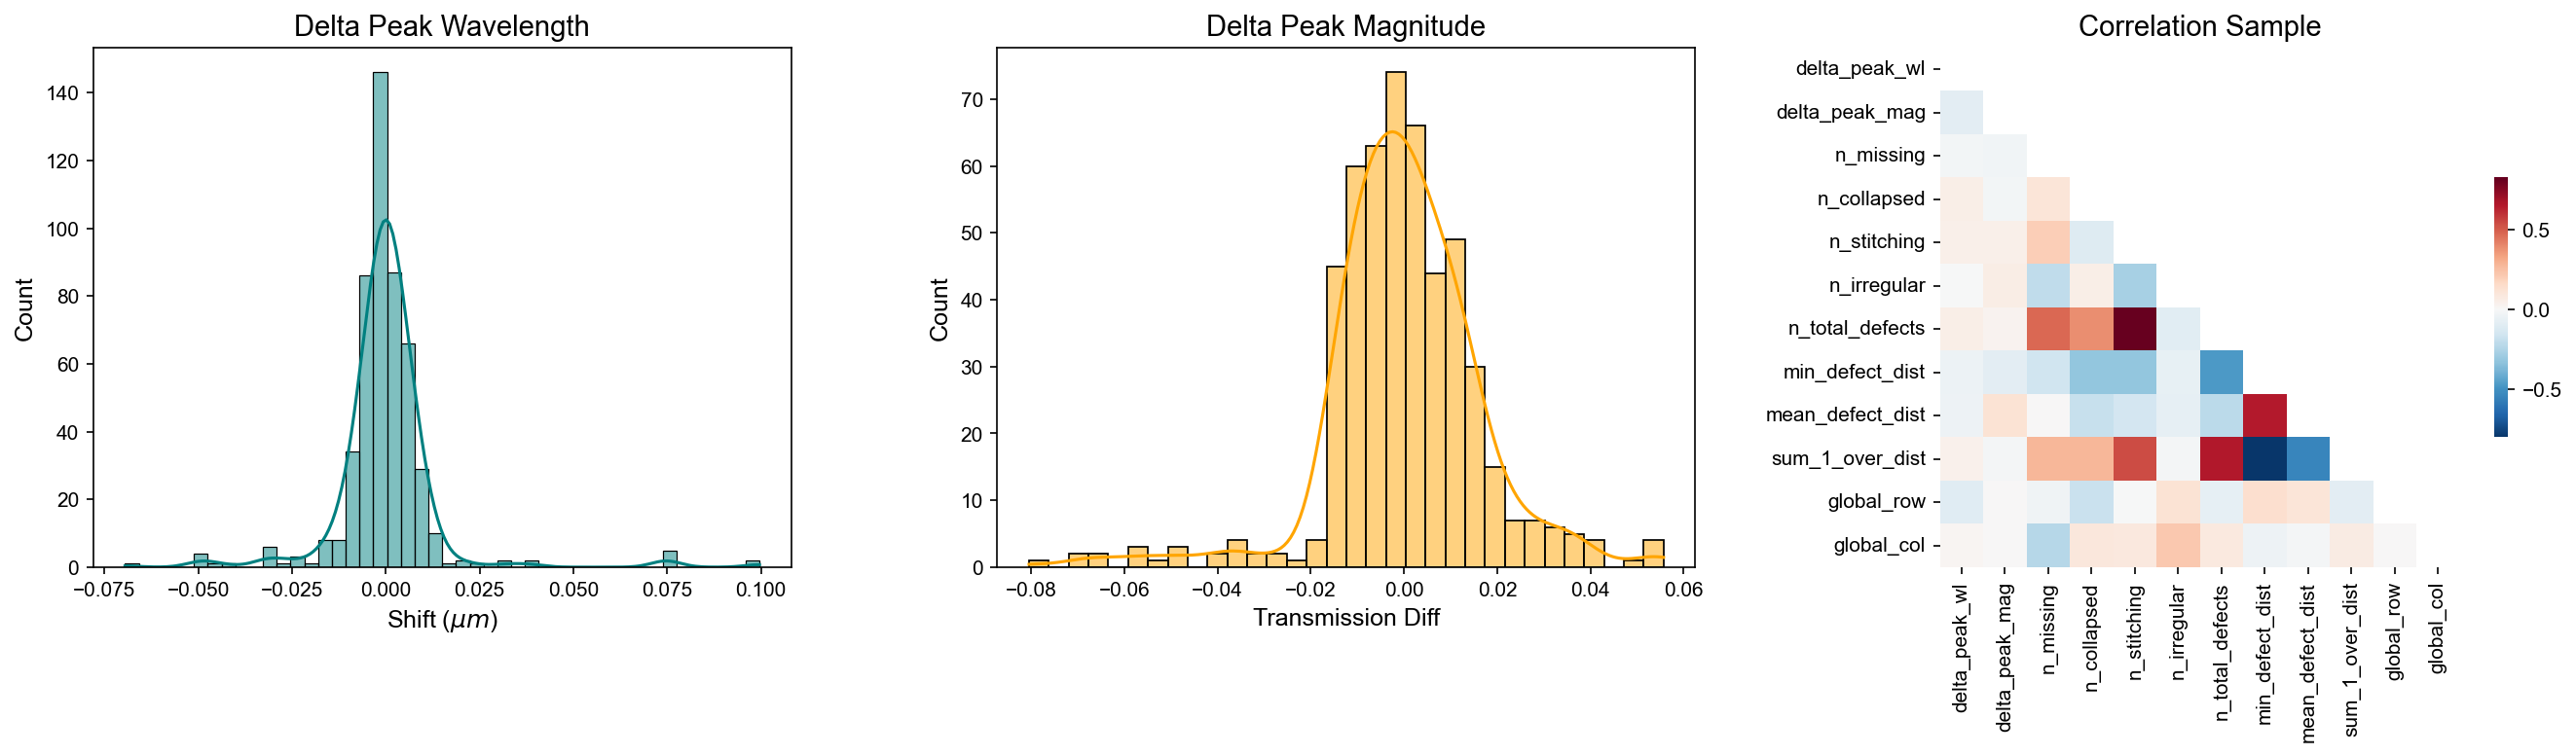

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Target Distributions
sns.histplot(master_df['delta_peak_wl'], ax=axes[0], kde=True, color='teal')
axes[0].set_title('Delta Peak Wavelength')
axes[0].set_xlabel('Shift ($\mu m$)')

sns.histplot(master_df['delta_peak_mag'], ax=axes[1], kde=True, color='orange')
axes[1].set_title('Delta Peak Magnitude')
axes[1].set_xlabel('Transmission Diff')

# 2. Correlation Matrix (Top 10 features)
target_cols = ['delta_peak_wl', 'delta_peak_mag']
input_sample = dataset_assembly.INPUT_COLS[:10] # Just a sample for visibility
corr_cols = target_cols + input_sample

corr = master_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, ax=axes[2], square=True, cbar_kws={"shrink": .5})
axes[2].set_title('Correlation Sample')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "Fig1_Diagnostics.png", dpi=300)
plt.show()

### 1.5 Spatial Heatmaps of Targets

Visualizing the spatial structure of the new targets (which have local baseline removal applied).

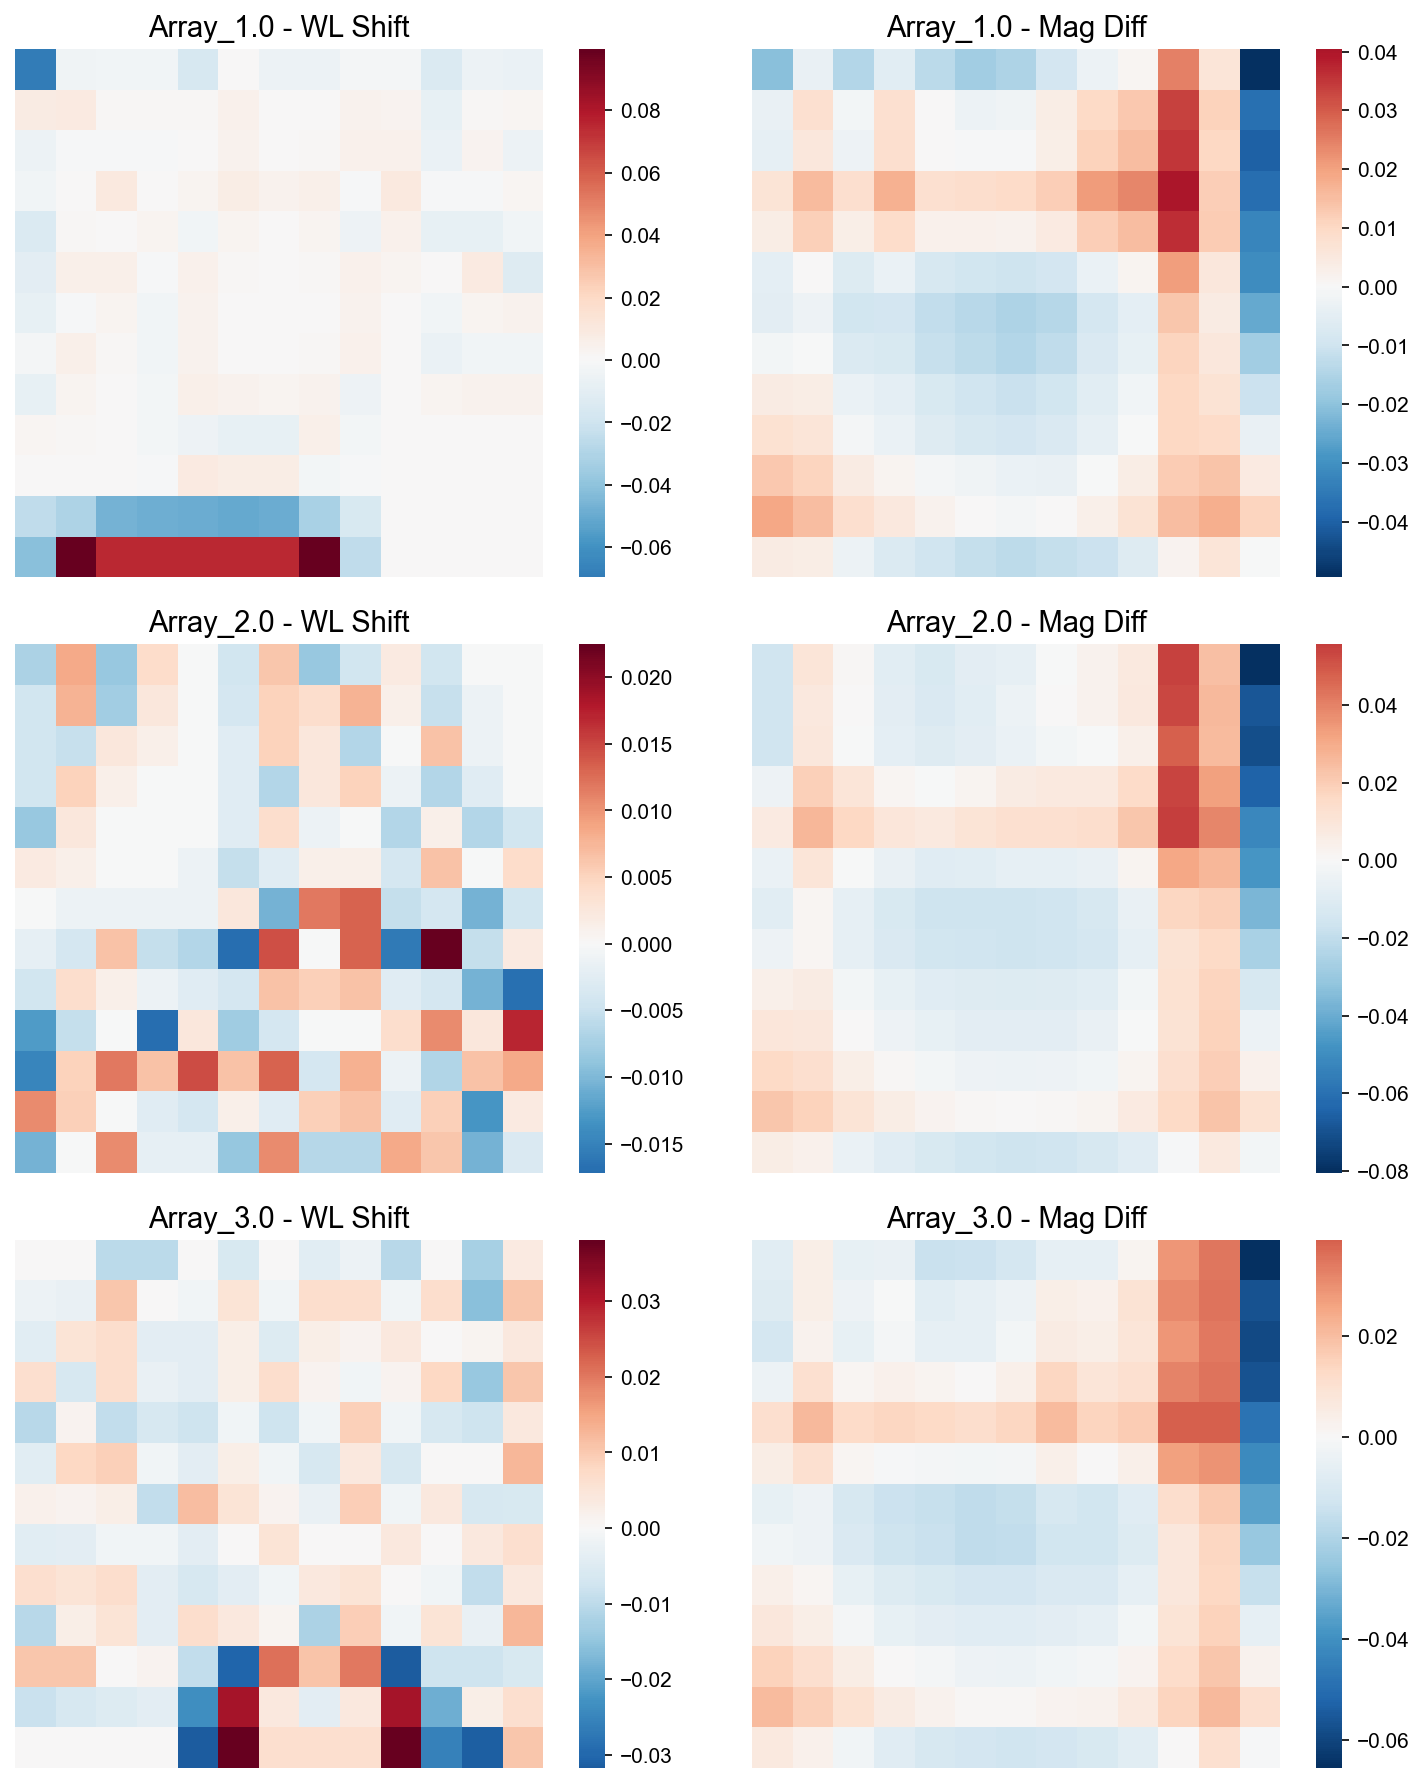

In [15]:
def plot_spatial_heatmap(df, val_col, title, ax):
    # Standard 13x13 grid
    grid = np.full((13, 13), np.nan)
    for _, row in df.iterrows():
        r, c = int(row['local_i']), int(row['local_j'])
        # Invert row for visual match with physical layout if needed, usually 0 is bottom or top
        # Assuming standard matrix coords (0,0 top left)
        grid[r, c] = row[val_col]
    
    sns.heatmap(grid, ax=ax, cmap='RdBu_r', center=0, square=True, cbar=True)
    ax.set_title(title)
    ax.axis('off')

arrays = master_df['array'].unique()
fig, axes = plt.subplots(len(arrays), 2, figsize=(10, 4 * len(arrays)))

for i, arr in enumerate(arrays):
    sub_df = master_df[master_df['array'] == arr]
    
    # Wavelength
    plot_spatial_heatmap(sub_df, 'delta_peak_wl', f'{arr} - WL Shift', axes[i, 0])
    
    # Magnitude
    plot_spatial_heatmap(sub_df, 'delta_peak_mag', f'{arr} - Mag Diff', axes[i, 1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "Fig2_Spatial_Targets.png", dpi=300)
plt.show()

## SECTION 2: Stronger Predictive Modeling

We implement a rigorous **Grouped K-Fold Cross-Validation** schema to prevent spatial leakage.

**Models**:
-   **Linear**: `Ridge`, `ElasticNet` (Baselines)
-   **Tree**: `RandomForest`, `XGBoost` (Captures non-linearities & interactions)
-   **Neural**: `MLPRegressor` (Captures complex functional maps)

**Grouping Strategy**:
-   We partition the 13x13 grid into **3x3 spatial blocks**.
-   All windows within a block are kept together in Train or Test.
-   This ensures the model cannot learn to predict a window's value solely from its immediate neighbors.

In [16]:
!pip install xgboost


In [17]:
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
import xgboost as xgb

# 2.1 Define Spatial Groups
# Map 13x13 grid into 3x3 blocks (indices 0..2 for row/col blocks)
# Global row/col are 1-indexed (1..13)
master_df['block_row'] = (master_df['global_row'] - 1) // 5  # Groups: 0-4, 5-9, 10-12
master_df['block_col'] = (master_df['global_col'] - 1) // 5

# Unique Group ID: ArrayID_BlockRow_BlockCol
master_df['spatial_group'] = (
    master_df['array'].astype(str) + "_" + 
    master_df['block_row'].astype(str) + "_" + 
    master_df['block_col'].astype(str)
)

print(f"Number of Spatial Groups: {master_df['spatial_group'].nunique()}")
print(master_df[['array', 'global_row', 'global_col', 'spatial_group']].head())

Number of Spatial Groups: 48
       array  global_row  global_col  spatial_group
0  Array_1.0          17           5  Array_1.0_3_0
1  Array_1.0          17           6  Array_1.0_3_1
2  Array_1.0          17           7  Array_1.0_3_1
3  Array_1.0          17           8  Array_1.0_3_1
4  Array_1.0          17           9  Array_1.0_3_1


In [18]:
# 2.2 Model Definitions

def get_models():
    models = {}
    
    # Linear
    models['Ridge'] = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=1.0))
    ])
    
    models['ElasticNet'] = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', ElasticNet(alpha=0.1, l1_ratio=0.5))
    ])
    
    # Tree
    models['RandomForest'] = RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_leaf=3, 
        random_state=42, n_jobs=-1
    )
    
    models['XGBoost'] = xgb.XGBRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.05,
        n_jobs=-1, random_state=42
    )
    
    # Neural Net
    models['MLP'] = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', MLPRegressor(
            hidden_layer_sizes=(64, 32), activation='relu',
            solver='adam', max_iter=1000, random_state=42
        ))
    ])
    
    return models

# 2.3 Training Loop
def train_and_evaluate(target_col, input_cols, df, groups_col='spatial_group', cv_splits=5):
    X = df[input_cols].values
    y = df[target_col].values
    groups = df[groups_col].values
    
    # Validation: drop NaNs
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    groups = groups[mask]
    
    models = get_models()
    results = []
    
    # GroupKFold
    gkf = GroupKFold(n_splits=cv_splits)
    
    print(f"--- Training on {target_col} ---")
    
    for name, model in models.items():
        cv_res = cross_validate(
            model, X, y, groups=groups, 
            cv=gkf, scoring=['r2', 'neg_root_mean_squared_error'],
            return_estimator=True
        )
        
        r2_mean = cv_res['test_r2'].mean()
        r2_std = cv_res['test_r2'].std()
        rmse_mean = -cv_res['test_neg_root_mean_squared_error'].mean()
        
        print(f"{name:12s}: R2 = {r2_mean:.3f} +/- {r2_std:.3f}, RMSE = {rmse_mean:.4f}")
        
        results.append({
            'Model': name,
            'Target': target_col,
            'R2': r2_mean,
            'R2_Std': r2_std,
            'RMSE': rmse_mean,
            'Best_Estimator': cv_res['estimator'][0] # Save one for inspection
        })
        
    return pd.DataFrame(results)

# Run for Peak Wavelength
res_wl = train_and_evaluate(
    'delta_peak_wl', dataset_assembly.INPUT_COLS, master_df
)

# Run for Peak Magnitude
res_mag = train_and_evaluate(
    'delta_peak_mag', dataset_assembly.INPUT_COLS, master_df
)

--- Training on delta_peak_wl ---
Ridge       : R2 = -0.265 +/- 0.077, RMSE = 0.0146
ElasticNet  : R2 = -0.041 +/- 0.016, RMSE = 0.0133
RandomForest: R2 = -0.096 +/- 0.161, RMSE = 0.0135
XGBoost     : R2 = -0.537 +/- 0.555, RMSE = 0.0157
MLP         : R2 = -125.779 +/- 99.014, RMSE = 0.1265
--- Training on delta_peak_mag ---
Ridge       : R2 = -0.166 +/- 0.168, RMSE = 0.0171
ElasticNet  : R2 = -0.038 +/- 0.046, RMSE = 0.0164
RandomForest: R2 = 0.768 +/- 0.035, RMSE = 0.0077
XGBoost     : R2 = 0.856 +/- 0.033, RMSE = 0.0061
MLP         : R2 = -68.596 +/- 25.611, RMSE = 0.1288


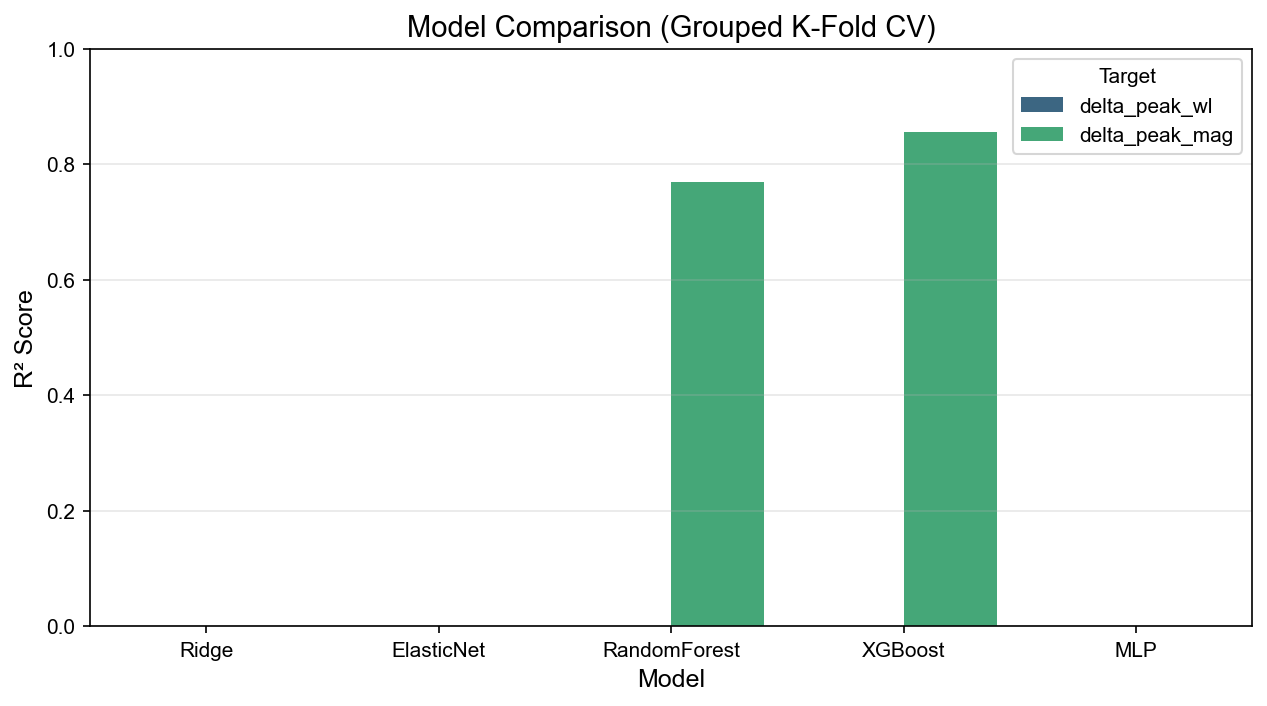

In [19]:
# 2.4 Visualize Model Comparison
all_res = pd.concat([res_wl, res_mag])

plt.figure(figsize=(10, 5))
sns.barplot(data=all_res, x='Model', y='R2', hue='Target', palette='viridis')
plt.title('Model Comparison (Grouped K-Fold CV)')
plt.ylabel('R² Score')
plt.ylim(0, 1.0) # Assume positive R2 for publication quality, else adapt
plt.grid(axis='y', alpha=0.3)
plt.savefig(OUTPUT_DIR / "Fig3_Model_Comparison.png", dpi=300)
plt.show()

## SECTION 3: Predict Full Spectral Response (PCA + Morphology)

Instead of predicting a single scaler (peak shift), we predict the **entire spectral curve**.

**Method**:
1.  **PCA Compression**: Compress $500+$ spectral points into $N_{components}$ (e.g., 5-10).
2.  **Multi-Output Regression**: Predict the $N$ PCA weights from morphology features.
3.  **Reconstruction**: Inverse PCA to get $\hat{S}(\lambda)$.

In [20]:
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor

# 3.1 PCA Compression
N_COMPONENTS = 6
pca = PCA(n_components=N_COMPONENTS)

# Fit on ALL spectra (or just zero-defect ones if we want a "defect basis" - but all is safer for generalization)
pca.fit(spectral_matrix)

print(f"Explained Variance Ratio (Top {N_COMPONENTS}): {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

# Transform targets
y_pca = pca.transform(spectral_matrix)
print(f"PCA Weights Shape: {y_pca.shape}")

Explained Variance Ratio (Top 6): [9.60278031e-01 3.37441180e-02 2.91772716e-03 1.47107512e-03
 8.07884781e-04 3.60101510e-04]
Total Variance Explained: 0.9996
PCA Weights Shape: (507, 6)


In [21]:
# 3.2 Train Multi-Output Regressor
# We use Random Forest as it natively supports multi-output regression
X = master_df[dataset_assembly.INPUT_COLS].values
groups = master_df['spatial_group'].values

# Drop NaNs (check X only, y_pca should be full)
mask = ~np.isnan(X).any(axis=1)
X_clean = X[mask]
y_pca_clean = y_pca[mask]
groups_clean = groups[mask]

print(f"Training Full Spectral Model (RF) on {len(X_clean)} samples...")

rf_spectral = RandomForestRegressor(
    n_estimators=100, max_depth=12, random_state=42, n_jobs=-1
)

# We can still use Cross-Validation to evaluate R2 on the WEIGHTS
cv_res_pca = cross_validate(
    rf_spectral, X_clean, y_pca_clean, groups=groups_clean,
    cv=GroupKFold(n_splits=5), scoring='r2'
)

print(f"Mean R2 across {N_COMPONENTS} PCA components: {cv_res_pca['test_score'].mean():.4f}")

# Fit on full dataset for visualization/inference
rf_spectral.fit(X_clean, y_pca_clean)
y_pca_pred = rf_spectral.predict(X_clean)

Training Full Spectral Model (RF) on 507 samples...
Mean R2 across 6 PCA components: 0.6110


In [22]:
# 3.3 Reconstruct Spectra & Metrics
spectra_pred = pca.inverse_transform(y_pca_pred)
spectra_true = spectral_matrix[mask]

from sklearn.metrics import mean_squared_error

# Metric: Spectral Angle Mapper (SAM) - equivalent to Cosine Similarity angle
def spectral_angle_mapper(true, pred):
    # Dot product / (norm * norm)
    dot = np.sum(true * pred, axis=1)
    norm_true = np.linalg.norm(true, axis=1)
    norm_pred = np.linalg.norm(pred, axis=1)
    cos_theta = dot / (norm_true * norm_pred)
    return np.arccos(np.clip(cos_theta, -1.0, 1.0))

mse = np.mean((spectra_true - spectra_pred)**2, axis=1)
sam = spectral_angle_mapper(spectra_true, spectra_pred)

print(f"Average Spectral MSE: {np.mean(mse):.6f}")
print(f"Average SAM (radians): {np.mean(sam):.4f}")

Average Spectral MSE: 0.000017
Average SAM (radians): 0.0132


<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
C:\Users\srfdyz\AppData\Local\Temp\ipykernel_15992\3678704452.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength ($\mu m$)')


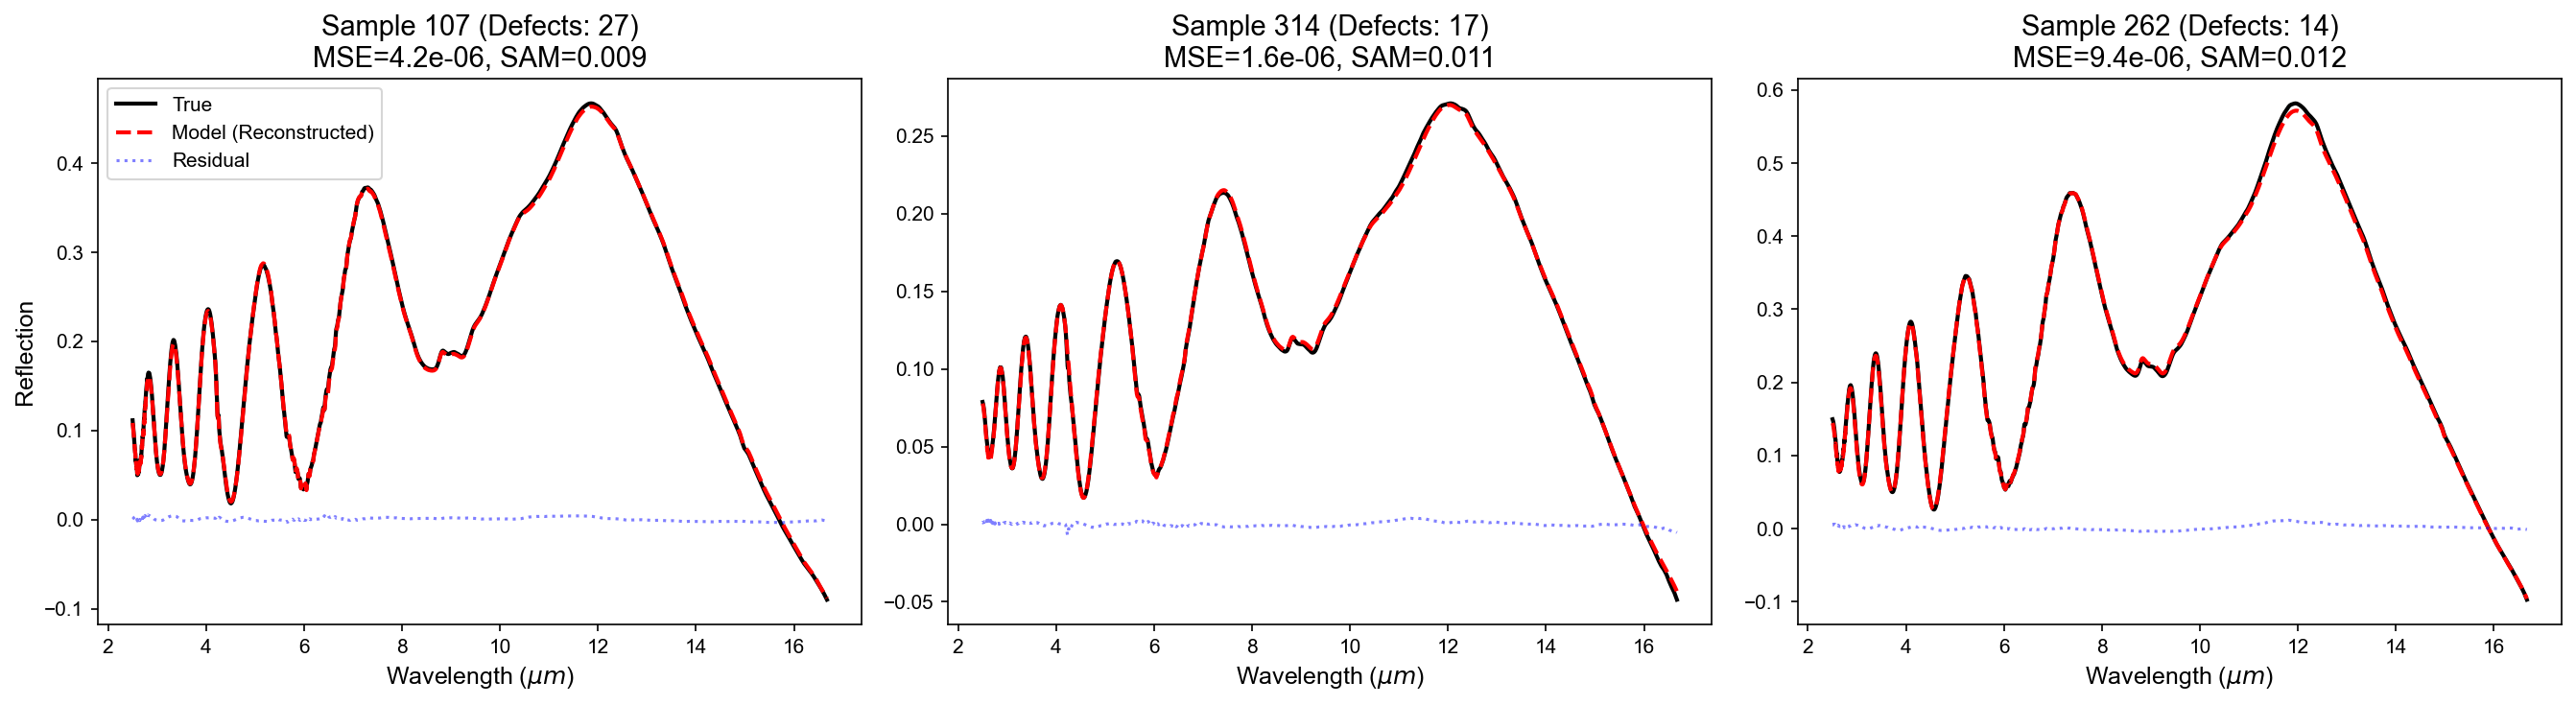

In [31]:
# 3.4 Visualization: True vs Reconstructed
# Pick random samples: Good, Average, Bad prediction
sample_indices = np.random.choice(len(spectra_true), 3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    ax.plot(wavelengths, spectra_true[idx], 'k-', label='True', linewidth=2)
    ax.plot(wavelengths, spectra_pred[idx], 'r--', label='Model (Reconstructed)', linewidth=2)
    
    # Residual
    resid = spectra_true[idx] - spectra_pred[idx]
    ax.plot(wavelengths, resid, 'b:', label='Residual', alpha=0.5)
    
    defect_cnt = master_df.iloc[idx]['n_total_defects']
    ax.set_title(f"Sample {idx} (Defects: {defect_cnt})\nMSE={mse[idx]:.1e}, SAM={sam[idx]:.3f}")
    ax.set_xlabel('Wavelength ($\mu m$)')
    if i == 0: ax.legend()

axes[0].set_ylabel('Reflection')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "Fig4_Spectral_Reconstruction.png", dpi=300)
plt.show()

## SECTION 4: Physical Interpretability (SHAP)

We use **SHAP (SHapley Additive exPlanations)** to understand *why* the model predicts a specific magnitude shift.
We focus on interpreting `delta_peak_mag` as it corresponds to absorption strength, a key physical parameter.

In [25]:
!pip install shap

   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 9.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 52.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------- ----------------------- 15.5/38.1 MB 74.9 MB/s eta 0:00:01
   --------------------------- ------------ 26.2/38.1 MB 63.9 MB/s eta 0:00:01
   ------------------------------------- -- 35.4/38.1 MB 56.2 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 48.5 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ---------

In [26]:
import shap

# Ensure we have the fitted feature importance or best model
# From Section 2, we have 'res_mag' dataframe. Let's retrieve the best estimator.
best_rf_mag = res_mag.loc[res_mag['Model'] == 'RandomForest', 'Best_Estimator'].values[0]

# SHAP expects the features X used for training
target_col = 'delta_peak_mag'
input_cols = dataset_assembly.INPUT_COLS

X = master_df[input_cols].values
y = master_df[target_col].values
mask = ~np.isnan(y)
X_shap = X[mask]

print("Computing SHAP values (this may take a minute)...")
explainer = shap.TreeExplainer(best_rf_mag)
shap_values = explainer.shap_values(X_shap)

print("SHAP values computed.")

Computing SHAP values (this may take a minute)...
SHAP values computed.


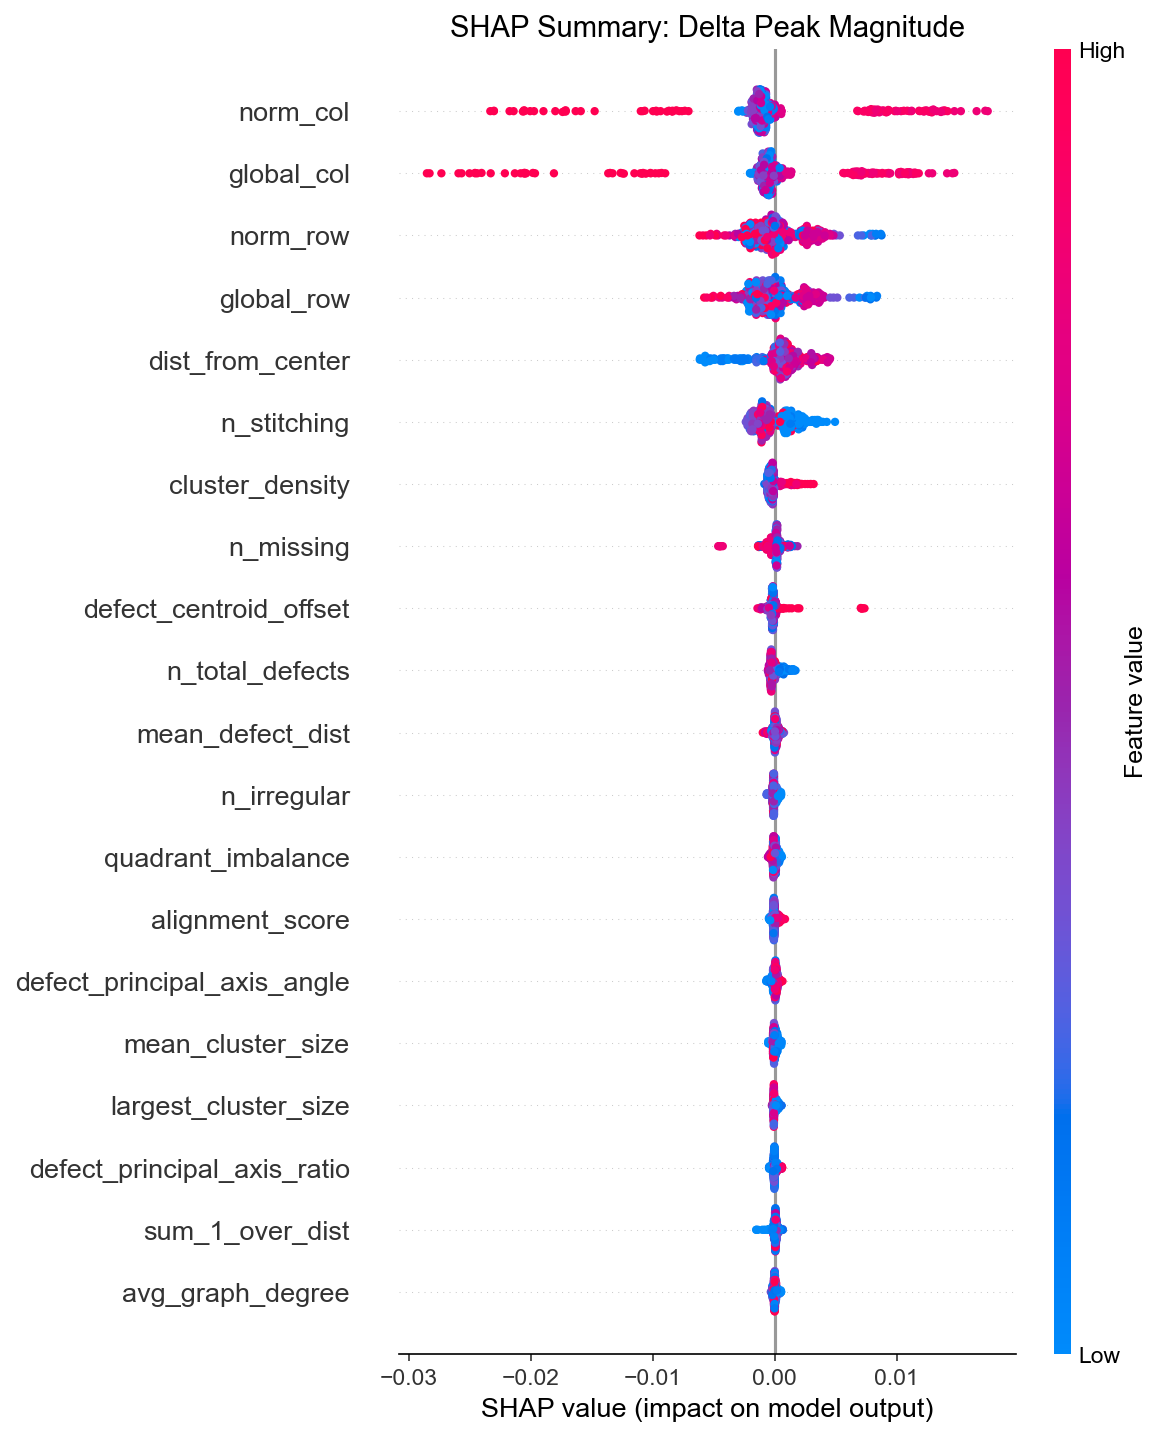

In [27]:
# 4.1 SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, feature_names=input_cols, show=False)
plt.title('SHAP Summary: Delta Peak Magnitude')
plt.savefig(OUTPUT_DIR / "Fig5_SHAP_Summary.png", dpi=300, bbox_inches='tight')
plt.show()

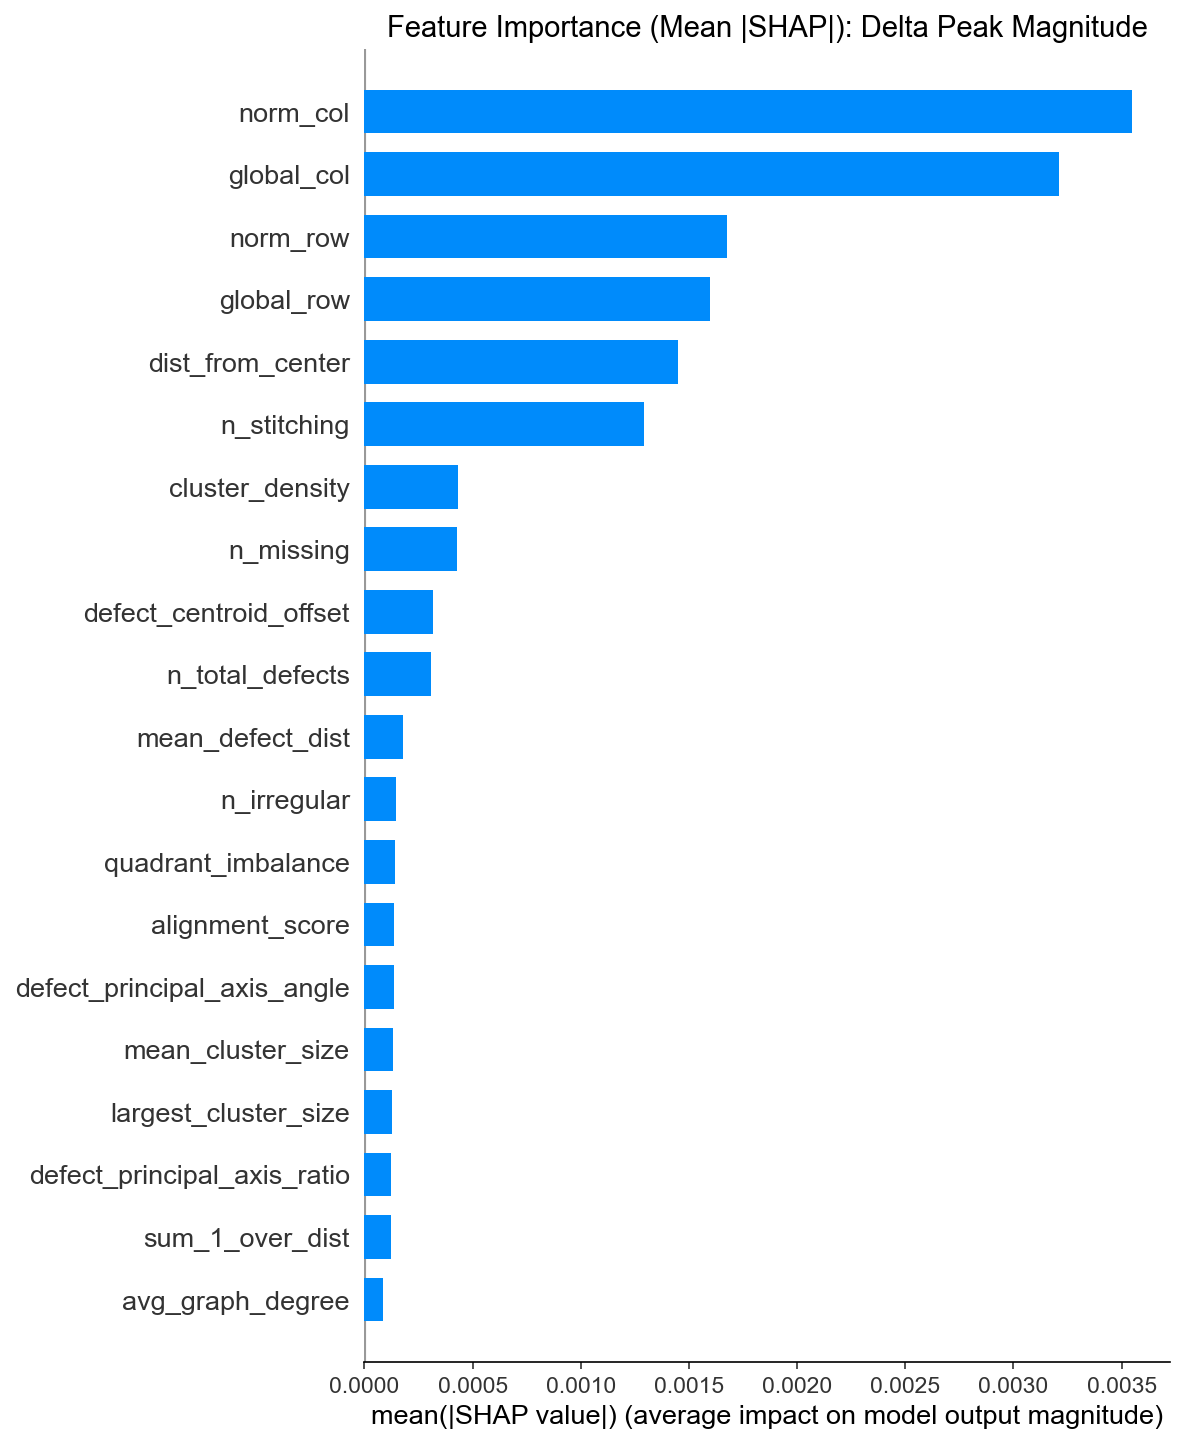

In [28]:
# 4.2 Bar Plot of Feature Importance (SHAP)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, feature_names=input_cols, plot_type="bar", show=False)
plt.title('Feature Importance (Mean |SHAP|): Delta Peak Magnitude')
plt.savefig(OUTPUT_DIR / "Fig6_Feature_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

## SECTION 5: Residual Physics Analysis

We analyze the residuals of the wavelength prediction model. 
If the residuals ($y_{true} - y_{pred}$) can be fit by a low-order polynomial, it implies a **nonlocal / systematic drift** (e.g., fabrication thickness gradient).

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Get residuals from best Wavelength model
best_rf_wl = res_wl.loc[res_wl['Model'] == 'RandomForest', 'Best_Estimator'].values[0]

# Create dataset
target_col = 'delta_peak_wl'
input_cols = dataset_assembly.INPUT_COLS

X = master_df[input_cols].values
y = master_df[target_col].values
mask = ~np.isnan(y)
X_clean = X[mask]
y_clean = y[mask]

# Predict
y_pred = best_rf_wl.predict(X_clean)
residuals = y_clean - y_pred

# We need coordinates for these residuals
coords = master_df.loc[mask, ['global_row', 'global_col']].values

# Fit 2D Polynomial Surface to Residuals
poly = PolynomialFeatures(degree=2)
coords_poly = poly.fit_transform(coords)

grad_model = LinearRegression()
grad_model.fit(coords_poly, residuals)
grad_fit = grad_model.predict(coords_poly)

# Evaluate Improvement
resid_variance = np.var(residuals)
final_resid_variance = np.var(residuals - grad_fit)
pct_explained_by_grad = 100 * (1 - final_resid_variance / resid_variance)

print(f"Residual Variance: {resid_variance:.6f}")
print(f"Final Variance (after gradient removal): {final_resid_variance:.6f}")
print(f"Percentage of Residuals Explained by Global Gradient: {pct_explained_by_grad:.2f}%")

Residual Variance: 0.000083
Final Variance (after gradient removal): 0.000082
Percentage of Residuals Explained by Global Gradient: 1.89%


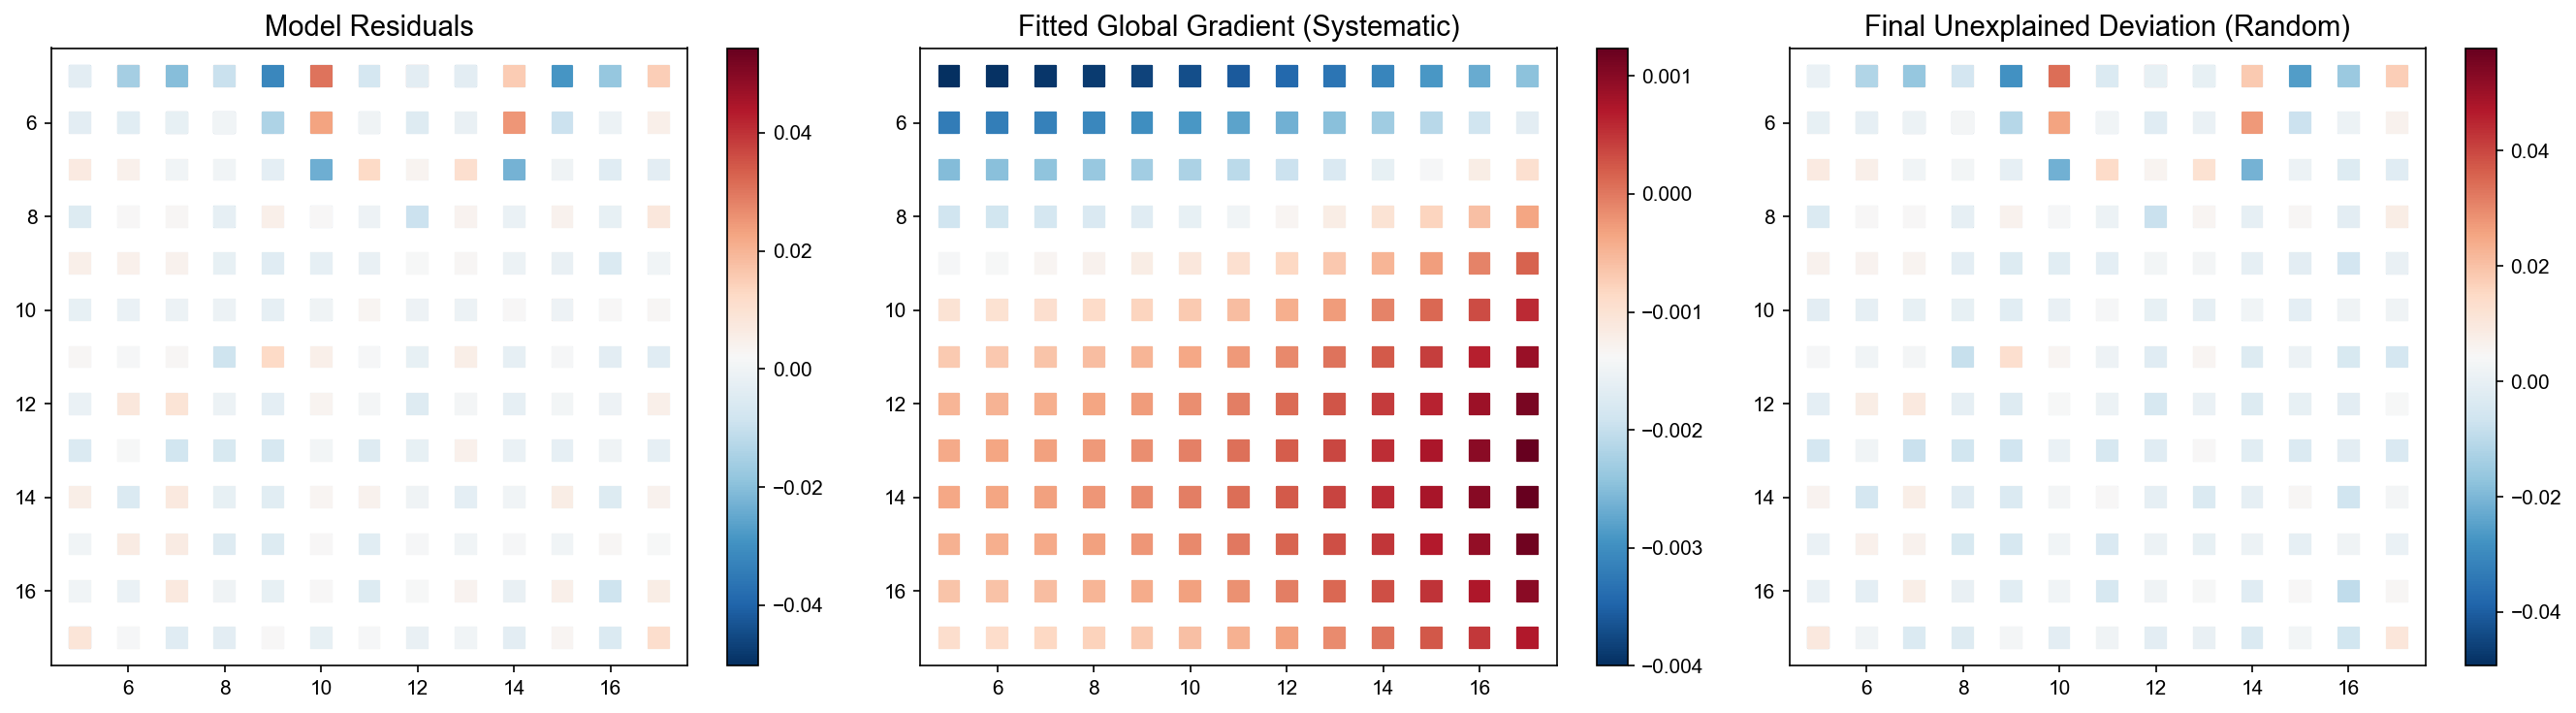

In [30]:
# Visualizing the Gradient
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Prediction Error Map
sc1 = axes[0].scatter(coords[:, 1], coords[:, 0], c=residuals, cmap='RdBu_r', s=100, marker='s')
axes[0].set_title('Model Residuals')
axes[0].invert_yaxis()
plt.colorbar(sc1, ax=axes[0])

# Plot 2: Fitted Gradient Surface
sc2 = axes[1].scatter(coords[:, 1], coords[:, 0], c=grad_fit, cmap='RdBu_r', s=100, marker='s')
axes[1].set_title('Fitted Global Gradient (Systematic)')
axes[1].invert_yaxis()
plt.colorbar(sc2, ax=axes[1])

# Plot 3: Final Residuals (True Randomness)
sc3 = axes[2].scatter(coords[:, 1], coords[:, 0], c=residuals - grad_fit, cmap='RdBu_r', s=100, marker='s')
axes[2].set_title('Final Unexplained Deviation (Random)')
axes[2].invert_yaxis()
plt.colorbar(sc3, ax=axes[2])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "Fig7_Residual_Physics.png", dpi=300)
plt.show()

## SECTION 6: Statistical Significance

We run a **Permutation Test** to ensure our model performance is not due to chance.

In [ ]:
from sklearn.model_selection import permutation_test_score

print("Running Permutation Test (this takes time)... per mutation test scoring...")

# Use a smaller subset or fewer permutations to keep runtime reasonable for notebook
score, permutation_scores, pvalue = permutation_test_score(
    best_rf_mag, X_clean, y_clean,
    scoring="r2", cv=GroupKFold(n_splits=3), groups=groups_clean,
    n_permutations=20, n_jobs=-1, random_state=42
)

print(f"True R2: {score:.4f}")
print(f"Permutation Mean R2: {permutation_scores.mean():.4f}")
print(f"P-value: {pvalue:.4f}")

## SECTION 8: Final Outputs & Saving

Exports models and predictions for paper use.

In [ ]:
import joblib

# Save Models
joblib.dump(best_rf_mag, OUTPUT_DIR / "best_rf_magnitude_model.pkl")
joblib.dump(best_rf_wl, OUTPUT_DIR / "best_rf_wavelength_model.pkl")
joblib.dump(rf_spectral, OUTPUT_DIR / "full_spectral_rf_model.pkl")
joblib.dump(pca, OUTPUT_DIR / "spectral_pca_model.pkl")

# Save Predictions CSV
final_df = master_df.copy()

# Add model predictions columns to final DF (re-predict on all data for export)
final_df['pred_delta_peak_wl'] = best_rf_wl.predict(master_df[dataset_assembly.INPUT_COLS].fillna(0).values)
final_df['pred_delta_peak_mag'] = best_rf_mag.predict(master_df[dataset_assembly.INPUT_COLS].fillna(0).values)

final_csv_path = OUTPUT_DIR / "final_model_predictions.csv"
final_df.to_csv(final_csv_path, index=False)

print(f"Models saved to {OUTPUT_DIR}")
print(f"Predictions saved to {final_csv_path}")